In [1]:
# -*-coding:utf-8-*-
%matplotlib inline
import os

import numpy as np
from matplotlib import pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.naive_bayes import MultinomialNB

from bald_latin import remove_cyrillic_and_accents
from dataset import CommentDataset, UnlabeledDataset

### Load the original and stemmed comments, and their labels.
Remove the cyrillic comments and remove accents from ć,č,ž,š,đ.

In [2]:
originals = open('dataset/lns/lns_comments.txt', 'r').readlines()
corpus = open('dataset/lns/lns_comments_stemmed.txt', 'r').readlines()
labels = open('dataset/lns/lns_labels.txt', 'r').readlines()

# scraped
scraped = open('dataset/scraped/comments_stemmed.txt').readlines()
scraped = UnlabeledDataset(scraped)

# remove cyrillic and balden text
corpus, labels = remove_cyrillic_and_accents(corpus, labels)
originals, _ = remove_cyrillic_and_accents(originals, range(len(originals)), remove_accents=False)

# labels as a numpy array
labels = np.array([int(float(x)) for x in labels])

# Train a Naive Bayes classifier using K-Fold crossvalidation
### Test it on each test set, average the results

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

croatian_stop_words = set([u"a",u"ako",u"ali",u"bi",u"bih",u"bila",u"bili",u"bilo",u"bio",u"bismo",u"biste",u"biti",u"bumo",u"da",u"do",u"duž",u"ga",u"hoće",u"hoćemo",u"hoćete",u"hoćeš",u"hoću",u"i",u"iako",u"ih",u"ili",u"iz",u"ja",u"je",u"jedna",u"jedne",u"jedno",u"jer",u"jesam",u"jesi",u"jesmo",u"jest",u"jeste",u"jesu",u"jim",u"joj",u"još",u"ju",u"kada",u"kako",u"kao",u"koja",u"koje",u"koji",u"kojima",u"koju",u"kroz",u"li",u"me",u"mene",u"meni",u"mi",u"mimo",u"moj",u"moja",u"moje",u"mu",u"na",u"nad",u"nakon",u"nam",u"nama",u"nas",u"naš",u"naša",u"naše",u"našeg",u"ne",u"nego",u"neka",u"neki",u"nekog",u"neku",u"nema",u"netko",u"neće",u"nećemo",u"nećete",u"nećeš",u"neću",u"nešto",u"ni",u"nije",u"nikoga",u"nikoje",u"nikoju",u"nisam",u"nisi",u"nismo",u"niste",u"nisu",u"njega",u"njegov",u"njegova",u"njegovo",u"njemu",u"njezin",u"njezina",u"njezino",u"njih",u"njihov",u"njihova",u"njihovo",u"njim",u"njima",u"njoj",u"nju",u"no",u"o",u"od",u"odmah",u"on",u"ona",u"oni",u"ono",u"ova",u"pa",u"pak",u"po",u"pod",u"pored",u"prije",u"s",u"sa",u"sam",u"samo",u"se",u"sebe",u"sebi",u"si",u"smo",u"ste",u"su",u"sve",u"svi",u"svog",u"svoj",u"svoja",u"svoje",u"svom",u"ta",u"tada",u"taj",u"tako",u"te",u"tebe",u"tebi",u"ti",u"to",u"toj",u"tome",u"tu",u"tvoj",u"tvoja",u"tvoje",u"u",u"uz",u"vam",u"vama",u"vas",u"vaš",u"vaša",u"vaše",u"već",u"vi",u"vrlo",u"za",u"zar",u"će",u"ćemo",u"ćete",u"ćeš",u"ću",u"što"])

# build tf-idf vectorizer which uses unigrams and bigrams.
# uses words with 2+ occurances as features
vectorizer = TfidfVectorizer(
    strip_accents="unicode",
    lowercase=True,
    ngram_range=(1, 2),
    min_df=10,
    norm='l2',
    smooth_idf=True,
    use_idf=True,
    stop_words=croatian_stop_words)

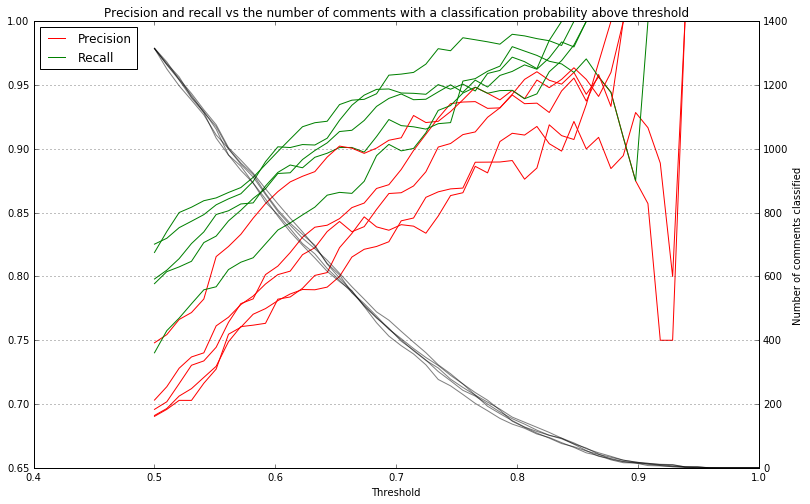

In [4]:
n_folds = 5
nums = []


# Split the dataset into k folds, each fold is a test set for one iteration
k_fold = KFold(len(corpus), n_folds=n_folds, shuffle=False)
for fold_count, (train, test) in enumerate(k_fold):
    corpus_train = [corpus[x] for x in train]
    corpus_test = [corpus[x] for x in test]
    labels_train = [labels[x] for x in train]
    labels_test = [labels[x] for x in test]
    
    # build the dataset, vectorize it using TF-IDF
    data = CommentDataset(corpus_train, labels_train, corpus_test, labels_test)
    data.X_train = vectorizer.fit_transform(data._comments_train)
    data.X_test  = vectorizer.transform(data._comments_test)
        
    # create and fit the classifier
    clf = MultinomialNB().fit(data.X_train, data.y_train)
    
    proba = clf.predict_proba(data.X_test)[:,1]
    
    # print precision for different thresholds
    thresholds = np.linspace(0.5, 1)
    accuracy, precision, recall, num_classified = [], [], [], []
    for threshold in thresholds:
        results = data.test_prediction_above(proba, threshold, print_options=[])
        accuracy.append(results[0]); precision.append(results[1]); recall.append(results[2]); 
        num_classified.append(np.sum(np.logical_or(proba < 1 - threshold, proba > threshold)))
            
    fig = plt.figure(1, figsize=(13, 8))
#     plt.plot(thresholds, accuracy, label="Accuracy" if fold_count == 0 else None, color='b', alpha=0.5)
    plt.plot(thresholds, precision, label="Precision" if not fold_count else None, color='r')
    plt.plot(thresholds, recall, label="Recall" if not fold_count else None, color='g')
    plt.legend(loc='upper left')
    nums.append(num_classified)

plt.xlabel("Threshold")
plt.twinx()
for num in nums:
    plt.plot(thresholds, num, label="Number of comments classified", color='k', alpha=0.5)

plt.title("Precision and recall vs the number of comments with a classification probability above threshold")
plt.ylabel("Number of comments classified")
plt.grid()
plt.show()

## Once we have picked a threshold for bot classification, lets classify the scraped comments
### With the scraped comments, add the scraped not-bots and train an LSTM

In [20]:
n_folds = 5
threshold = 0.84
max_scraped = 10**5

# Split the dataset into k folds, each fold is a test set for one iteration
k_fold = KFold(len(corpus), n_folds=n_folds, shuffle=False)
for fold_count, (train, test) in enumerate(k_fold):
    corpus_train = [corpus[x] for x in train]
    corpus_test = [corpus[x] for x in test]
    labels_train = [labels[x] for x in train]
    labels_test = [labels[x] for x in test]
    
    # build the dataset, vectorize it using TF-IDF
    data = CommentDataset(corpus_train, labels_train, corpus_test, labels_test)
    data.X_train = vectorizer.fit_transform(data._comments_train)
    data.X_test  = vectorizer.transform(data._comments_test)
    scraped.X = vectorizer.transform(scraped.comments[:max_scraped])
        
    # create and fit the classifier
    clf = MultinomialNB().fit(data.X_train, data.y_train)
    
    proba = clf.predict_proba(scraped.X)[:,1]
    indices = list(np.argwhere(proba > threshold).flatten())
    print "Classified {} comments as bots".format(len(indices))
    
    scraped.bots = [scraped.comments[x] for x in indices]
    
    print scraped_bots[:10]
    

539
 mer koj se moraju preduzet za bolj buducnost srbij svakak ne mogu biti bezboln 

 svakak i gradjan srbij su to zasluzi 

 slaz se sa tob i ja misli ist 

 veruj da ce vinovnic ov incident biti brz uhapsen 

 pajtic je pokaza svoji ponasanj da sam los stvar mozem ocekiva od njeg 

 pajtic je zaist pokaza da ne prez ni od kakv gadost u svoj prljav politick borb 

 pajtic je otpeva svoj 

 navika je narod na ovakv ponasanj pajtic 

 pajtic je zlo 

 šutanovc bij žen pajtić vredj nacionaln manjin i to sve film demokratij u ostavc 

 ov je svakak pozitivn vest 

 i mađar u vojvodin su za vučić i sns i to je sasv logičn videl su ko su demokra 

 odličn saradnj i odnos su najbitn za naš regij još jedn u niz priznanj i podršk za srbij 

 slaz se sa tob 

 pajtic je rekorder u proneveram 

 pajtic je poniz i osiromasi gradjan vojvodin 

 tacn tak ds na cel sa pajtic nikak ne moz biti buducnost vojvodin vrl verovatn je njihov odlazak u istorij razlog je za to veom mnog izneveri su poverenj 

NameError: name 'scraped_bots' is not defined

## Label a dataset from the scraped comments and train the network on it
### For each fold, train a separate network

In [ ]:
n_folds=3
values = np.zeros(3)  # accuracy, precision, recall
probabilities = []

# Split the dataset into k folds, each fold is a test set for one iteration
k_fold = KFold(len(corpus), n_folds=n_folds, shuffle=True)
for fold_count, (train, test) in enumerate(k_fold):
#     print "Fold #{}".format(fold_count)
    corpus_train = [corpus[x] for x in train]
    corpus_test = [corpus[x] for x in test]
    labels_train = [labels[x] for x in train]
    labels_test = [labels[x] for x in test]
    
    # build the dataset, vectorize it using TF-IDF
    data = CommentDataset(corpus_train, labels_train, corpus_test, labels_test)
    data.vectorize_fit()
        
    # create and fit the classifier
    clf = MultinomialNB().fit(data.X_train, data.y_train)
    
    proba = clf.predict_proba(data.X_test)[:,1]
    probabilities.append(proba)
    
    values += data.test_prediction(proba, print_options=[])[:3]  # for averaging metrics on k-folds
    
print "Results on {} folds:".format(fold_count + 1)
print ("Accuracy: {},\nPrecision: {},\nRecall: {}".format(values[0]/n_folds, values[1]/n_folds, values[2]/n_folds))


# plots
plt.figure(figsize=(13, 4))
for fold, proba in enumerate(probabilities):
    n, bins, patches = plt.hist(proba, 100, alpha=0.5, label="Fold #{}".format(fold))
plt.legend(loc='upper right')
plt.show()